Median DOY for green-up in my other code:   
* 2023:108
* 2024:103
* 2025:109

Potentially normalize the NDVI by dividing by GDD since predicted green-up date

### Import

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import xarray as xr
import datetime



### Rasterize Crop Masks (Make it 1 if wheat, 0 otherwise)

In [24]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np
import os
from shapely.geometry import box

# === Settings ===

output_dir = "rasterized_masks"
os.makedirs(output_dir, exist_ok=True)

# Sentinel-2 resolution in meters
pixel_size = 10

# === Step 1: Load Huron County boundary ===
county_gdf = gpd.read_file('huron_county.geojson')
county_gdf = county_gdf.to_crs("EPSG:32617")  # Sentinel-2 UTM zone for Michigan Thumb

bounds = county_gdf.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds

# === Step 2: Define raster grid ===
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# === Step 3: Set raster metadata ===
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "uint8",
    "crs": "EPSG:32617",
    "transform": transform,
}

# === Step 4: Rasterize each crop mask ===
for year in range(2019, 2025):
    mask_path = os.path.join(f"huron_winter_wheat_{year}.geojson")
    if not os.path.exists(mask_path):
        continue

    gdf = gpd.read_file(mask_path).to_crs("EPSG:32617")
    
    mask = rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    out_raster_path = os.path.join(output_dir, f"winter_wheat_mask_{year}.tif")
    with rasterio.open(out_raster_path, "w", **meta) as dst:
        dst.write(mask, 1)

    print(f"Saved: {out_raster_path}")


Saved: rasterized_masks\winter_wheat_mask_2019.tif
Saved: rasterized_masks\winter_wheat_mask_2020.tif
Saved: rasterized_masks\winter_wheat_mask_2021.tif
Saved: rasterized_masks\winter_wheat_mask_2022.tif
Saved: rasterized_masks\winter_wheat_mask_2023.tif
Saved: rasterized_masks\winter_wheat_mask_2024.tif


#### Test to see if the raster works

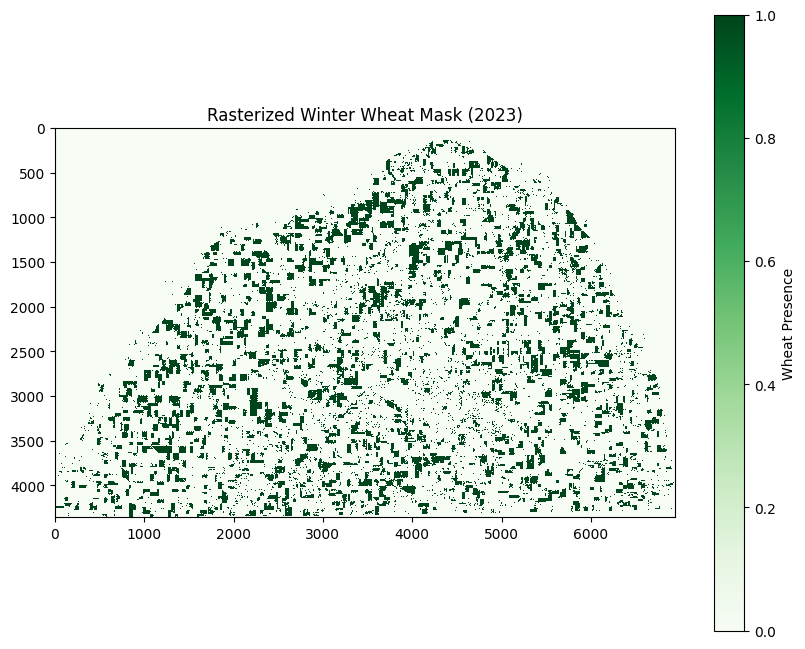

In [25]:
import rasterio
import matplotlib.pyplot as plt

# Example: view 2023 raster
with rasterio.open("rasterized_masks/winter_wheat_mask_2023.tif") as src:
    mask = src.read(1)

plt.figure(figsize=(10, 8))
plt.imshow(mask, cmap="Greens", interpolation="nearest")
plt.title("Rasterized Winter Wheat Mask (2023)")
plt.colorbar(label="Wheat Presence")
plt.show()


In [15]:
import json
from shapely.geometry import shape
from pystac_client import Client

# Step 1: Load the GeoJSON file
with open("huron_county.geojson") as f:
    geojson = json.load(f)

# Step 2: Extract the geometry (assumes single feature)
geometry = shape(geojson["features"][0]["geometry"])

# Step 3: Use as `intersects` in your STAC search
catalog = Client.open("https://earth-search.aws.element84.com/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime="2019-01-01/2025-05-01",
    query={"eo:cloud_cover": {"lt": 30}},
    max_items=5000

    #limit=5
)


In [16]:
# # Step 4: Collect and inspect results
items = list(search.items())
print(f"Found {len(items)} Sentinel-2 scenes for Huron County in June 2024")


print("Available bands in first scene:")
for asset_key in items[0].assets.keys():
    print(" -", asset_key)

Found 765 Sentinel-2 scenes for Huron County in June 2024
Available bands in first scene:
 - aot
 - blue
 - cloud
 - coastal
 - granule_metadata
 - green
 - nir
 - nir08
 - nir09
 - product_metadata
 - red
 - rededge1
 - rededge2
 - rededge3
 - scl
 - snow
 - swir16
 - swir22
 - tileinfo_metadata
 - visual
 - wvp
 - thumbnail
 - aot-jp2
 - blue-jp2
 - coastal-jp2
 - green-jp2
 - nir-jp2
 - nir08-jp2
 - nir09-jp2
 - red-jp2
 - rededge1-jp2
 - rededge2-jp2
 - rededge3-jp2
 - scl-jp2
 - swir16-jp2
 - swir22-jp2
 - visual-jp2
 - wvp-jp2


In [17]:
from pyproj import Transformer
from shapely.ops import transform

project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds


In [18]:
stack = stackstac.stack(
    items,
    assets=["red", "nir", "scl"],
    resolution=10,
    epsg=32617,
    bounds=(minx, miny, maxx, maxy),
    dtype="float64"
)

# Select bands
red = stack.sel(band="red")
nir = stack.sel(band="nir")
scl = stack.sel(band="scl")

# Cloud mask using SCL classes:
# 1 - saturated/defective, 3 - shadows, 8–10 - clouds, 11 - snow/ice
cloud_mask = ~scl.isin([1, 3, 8, 9, 10, 11])

# Mask bad pixels
red_masked = red.where(cloud_mask)
nir_masked = nir.where(cloud_mask)

# NDVI calculation
ndvi = (nir_masked - red_masked) / (nir_masked + red_masked)
ndvi = ndvi.assign_coords(time=stack.time)
ndvi = ndvi.clip(min=-1.0, max=1.0)

## LAI
# Mask NDVI values below a vegetation threshold
ndvi_clean = ndvi.where(ndvi > 0.2)  # Mask anything likely not vegetation

# Apply LAI formula
lai = 6.0 * ndvi_clean - 2.0

# Optional: Ensure no negative LAI
lai = lai.clip(min=0)


saving them

In [28]:
import numpy as np

# Select first time slice
ndvi_first = ndvi.isel(time=0).values  # get numpy array
np.save("ndvi_first_slice.npy", ndvi_first)


In [29]:
np.savez_compressed("ndvi_first_slice_compressed.npz", ndvi_first)


In [27]:
import rioxarray

# Ensure CRS is set
ndvi = ndvi.rio.write_crs("EPSG:32617")

# Select the first time slice
ndvi_first = ndvi.isel(time=0)

# Save to GeoTIFF
ndvi_first.rio.to_raster("ndvi_first_slice.tif")


In [26]:
lai

<xarray.DataArray 'stackstac-07172ee2134ac090561eae1bce59e6d5' (time: 765,
                                                                y: 4358, x: 6943)> Size: 185GB
dask.array<clip, shape=(765, 4358, 6943), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/50)
    id                                       (time) <U24 73kB 'S2B_17TLJ_2019...
  * x                                        (x) float64 56kB 3.011e+05 ... 3...
  * y                                        (y) float64 35kB 4.881e+06 ... 4...
    instruments                              <U3 12B 'msi'
    mgrs:grid_square                         (time) <U2 6kB 'LJ' 'GP' ... 'GP'
    s2:sequence                              (time) <U1 3kB '0' '0' ... '1' '1'
    ...                                       ...
    view:azimuth                             (time) object 6kB None ... 274.8...
    proj:centroid                            (time) object 6kB None ... {'lat...
    s2:tile_id                               (time) object 6kB None ... 'S2A_...
    s2:mgrs_tile                             (time) object 6kB None ... None
    epsg                                     int64 8B 32617
  * time                                     (time) datetime64[ns] 6kB 2019-0...

## Getting Images

### 2023

In [147]:
import json
from shapely.geometry import shape
from pystac_client import Client
import numpy as np

# April 19 2023
# April 13 2024
# April 20 2025

# --- User-defined inputs ---
target_date = np.datetime64("2023-04-19")
days_window = 30  # how many days before/after target to search
n_closest = 3     # how many closest scenes you want
required_tile = "17TLJ"  # Sentinel-2 tile to filter on

# --- Load AOI geometry ---
with open("huron_county.geojson") as f:
    geojson = json.load(f)
geometry = shape(geojson["features"][0]["geometry"])

# --- STAC search around the target date ---
start = str(target_date)
end = str(target_date + np.timedelta64(days_window, "D"))

catalog = Client.open("https://earth-search.aws.element84.com/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime=f"{start}/{end}",
    query={"eo:cloud_cover": {"lt": 20}},
    max_items=100
)
items_all = list(search.items())

# --- Filter to only items strictly after the target date ---
items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]

# --- Further filter by tile ID ---
items_after = [item for item in items_after if item.id.split("_")[1] == required_tile]

# --- Sort by time (soonest after target date) ---
items_after.sort(key=lambda item: np.datetime64(item.datetime))

# --- Take top N closest items after the date ---
items = items_after[:n_closest]

print(f"Using {len(items)} closest Sentinel-2 scenes after {target_date} from tile {required_tile}:")
for item in items:
    print(item.id, item.datetime)


Using 3 closest Sentinel-2 scenes after 2023-04-19 from tile 17TLJ:
S2A_17TLJ_20230427_0_L2A 2023-04-27 16:41:16.124000+00:00
S2B_17TLJ_20230509_0_L2A 2023-05-09 16:31:22.398000+00:00
S2A_17TLJ_20230517_0_L2A 2023-05-17 16:41:17.603000+00:00


C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\3492744555.py:36: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]
C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\3492744555.py:42: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after.sort(key=lambda item: np.datetime64(item.datetime))


In [ ]:
#make it may 9
#for some reason teh for loop only does the last entry in my items. Since I only wanted the 2nd one I just cut off the last one.


items=items[:2]


In [151]:
from pyproj import Transformer
from shapely.ops import transform

# --- Transform AOI to UTM ---
project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds


# Bands to use
bands_to_use = [
    "red", "green", "blue", "nir", "rededge1", "rededge2", "rededge3",
    "swir16", "swir22", "scl","nir08"
]

# Vegetation index functions
def compute_evi(nir, red, blue):
    return 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)

def compute_ndre(nir, rededge):
    return (nir - rededge) / (nir + rededge)

def compute_ndwi(nir, swir16):
    return (nir - swir16) / (nir + swir16)



for item in items:
    date_str = item.datetime.strftime("%Y%m%d")
    tile_id = item.id.split("_")[1]
    var_suffix = f"{date_str}_{tile_id}"

    stack = stackstac.stack(
        [item],
        assets=bands_to_use,
        resolution=10,
        epsg=32617,
        bounds=(minx, miny, maxx, maxy),
        dtype="float64"
    )

    red = stack.sel(band="red").squeeze()
    green = stack.sel(band="green").squeeze()
    blue = stack.sel(band="blue").squeeze()
    nir = stack.sel(band="nir").squeeze()
    rededge1 = stack.sel(band="rededge1").squeeze()
    rededge2 = stack.sel(band="rededge2").squeeze()
    rededge3 = stack.sel(band="rededge3").squeeze()
    swir16 = stack.sel(band="swir16").squeeze()
    swir22 = stack.sel(band="swir22").squeeze()
    scl = stack.sel(band="scl").squeeze()
    nir08=stack.sel(band="nir08").squeeze()

    bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]
    valid_mask = ~scl.isin(bad_scl)

    red = red.where(valid_mask)
    green = green.where(valid_mask)
    blue = blue.where(valid_mask)
    nir = nir.where(valid_mask)
    rededge1 = rededge1.where(valid_mask)
    rededge2 = rededge2.where(valid_mask)
    rededge3 = rededge3.where(valid_mask)
    swir16 = swir16.where(valid_mask)
    swir22 = swir22.where(valid_mask)
    nir08 = nir08.where(valid_mask)


    ndvi = (nir - red) / (nir + red)
    ndvi = ndvi.clip(min=-1, max=1)

    evi = compute_evi(nir, red, blue).clip(min=-1, max=1)
    ndre = compute_ndre(nir, rededge1).clip(min=-1, max=1)

    ndwi = compute_ndwi(nir, swir16).clip(min=-1, max=1)


    lai = 6.0 * ndvi.where(ndvi > 0.2) - 2.0
    lai = lai.clip(min=0)

    ds = xr.Dataset({
        "ndvi": ndvi,
        "evi": evi,
        "ndre": ndre,
        "ndwi": ndwi,
        "lai": lai,
        "red": red,
        "green": green,
        "blue": blue,
        "nir": nir,
        "rededge1": rededge1,
        "rededge2": rededge2,
        "rededge3": rededge3,
        "swir16": swir16,
        "swir22": swir22,
        "nir08": nir08
    })

   # Save all computed bands and indices to globals
for name, arr in ds.data_vars.items():
    globals()[f"{name}_{var_suffix}"] = arr
    print(f"Saved {name}_{var_suffix}")

Saved ndvi_20230509_17TLJ
Saved evi_20230509_17TLJ
Saved ndre_20230509_17TLJ
Saved ndwi_20230509_17TLJ
Saved lai_20230509_17TLJ
Saved red_20230509_17TLJ
Saved green_20230509_17TLJ
Saved blue_20230509_17TLJ
Saved nir_20230509_17TLJ
Saved rededge1_20230509_17TLJ
Saved rededge2_20230509_17TLJ
Saved rededge3_20230509_17TLJ
Saved swir16_20230509_17TLJ
Saved swir22_20230509_17TLJ
Saved nir08_20230509_17TLJ


In [ ]:
# import stackstac
# import xarray as xr
# import numpy as np

# from pyproj import Transformer
# from shapely.ops import transform

# # --- Transform AOI to UTM ---
# project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
# geometry_utm = transform(project, geometry)
# minx, miny, maxx, maxy = geometry_utm.bounds

# # --- Loop through items ---
# for item in items:
#     date_str = item.datetime.strftime("%Y%m%d")
#     tile_id = item.id.split("_")[1]  # e.g., "17TLJ" from "S2A_17TLJ_..."

#     var_suffix = f"{date_str}_{tile_id}"  # e.g., "20230427_17TLJ"

#     # Stack only this item
#     stack = stackstac.stack(
#         [item],
#         assets=["red", "nir", "scl"],
#         resolution=10,
#         epsg=32617,
#         bounds=(minx, miny, maxx, maxy),
#         dtype="float64"
#     )

#     # Extract bands
#     red = stack.sel(band="red").squeeze()
#     nir = stack.sel(band="nir").squeeze()
#     scl = stack.sel(band="scl").squeeze()

#     # Cloud/shadow/snow mask
#     bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]
#     valid_mask = ~scl.isin(bad_scl)

#     red_masked = red.where(valid_mask)
#     nir_masked = nir.where(valid_mask)

#     # NDVI
#     ndvi = (nir_masked - red_masked) / (nir_masked + red_masked)
#     ndvi = ndvi.clip(min=-1.0, max=1.0)

#     # LAI
#     ndvi_clean = ndvi.where(ndvi > 0.2)
#     lai = 6.0 * ndvi_clean - 2.0
#     lai = lai.clip(min=0)

#     # Save to uniquely named variables
#     globals()[f"ndvi_{var_suffix}"] = ndvi
#     globals()[f"lai_{var_suffix}"] = lai

#     print(f"Saved NDVI and LAI to variables: ndvi_{var_suffix}, lai_{var_suffix}")


Saved NDVI and LAI to variables: ndvi_20230427_17TLJ, lai_20230427_17TLJ
Saved NDVI and LAI to variables: ndvi_20230509_17TLJ, lai_20230509_17TLJ
Saved NDVI and LAI to variables: ndvi_20230517_17TLJ, lai_20230517_17TLJ


Figure out what the NDVI and LAI should be at when the green up was estimated on April 19

In [130]:
ndvi_20230509_17TLJ.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()


KeyboardInterrupt: 

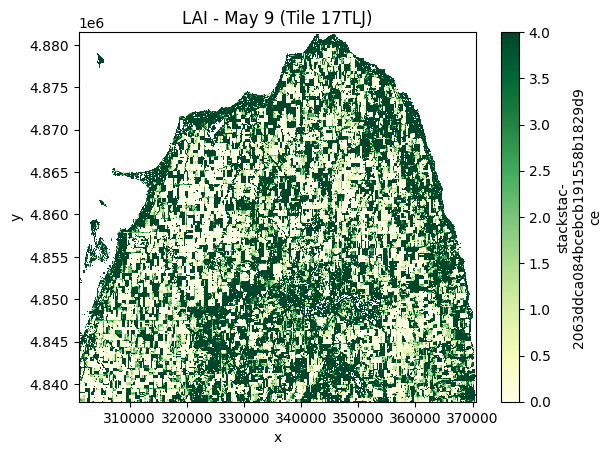

In [ ]:
lai_20230509_17TLJ.plot(cmap="YlGn", robust=True)
plt.title("LAI - May 9 (Tile 17TLJ)")
plt.show()


### 2024

In [9]:
import json
from shapely.geometry import shape
from pystac_client import Client
import numpy as np

# April 19 2023
# April 13 2024
# April 20 2025

# --- User-defined inputs ---
target_date = np.datetime64("2024-04-13")
days_window = 30  # how many days before/after target to search
n_closest = 3     # how many closest scenes you want
required_tile = "17TLJ"  # Sentinel-2 tile to filter on

# --- Load AOI geometry ---
with open("huron_county.geojson") as f:
    geojson = json.load(f)
geometry = shape(geojson["features"][0]["geometry"])

# --- STAC search around the target date ---
start = str(target_date)
end = str(target_date + np.timedelta64(days_window, "D"))

catalog = Client.open("https://earth-search.aws.element84.com/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime=f"{start}/{end}",
    query={"eo:cloud_cover": {"lt": 10}},
    max_items=100
)
items_all = list(search.items())

# --- Filter to only items strictly after the target date ---
items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]

# --- Further filter by tile ID ---
items_after = [item for item in items_after if item.id.split("_")[1] == required_tile]

# --- Sort by time (soonest after target date) ---
items_after.sort(key=lambda item: np.datetime64(item.datetime))

# --- Take top N closest items after the date ---
items = items_after[:n_closest]

print(f"Using {len(items)} closest Sentinel-2 scenes after {target_date} from tile {required_tile}:")
for item in items:
    print(item.id, item.datetime)


Using 2 closest Sentinel-2 scenes after 2024-04-13 from tile 17TLJ:
S2B_17TLJ_20240413_0_L2A 2024-04-13 16:31:20.466000+00:00
S2A_17TLJ_20240501_0_L2A 2024-05-01 16:41:18.851000+00:00


C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\585504590.py:36: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]
C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\585504590.py:42: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after.sort(key=lambda item: np.datetime64(item.datetime))


In [10]:
import stackstac
import xarray as xr
import numpy as np

from pyproj import Transformer
from shapely.ops import transform

# --- Transform AOI to UTM ---
project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds

# --- Loop through items ---
for item in items:
    date_str = item.datetime.strftime("%Y%m%d")
    tile_id = item.id.split("_")[1]  # e.g., "17TLJ" from "S2A_17TLJ_..."

    var_suffix = f"{date_str}_{tile_id}"  # e.g., "20230427_17TLJ"

    # Stack only this item
    stack = stackstac.stack(
        [item],
        assets=["red", "nir", "scl"],
        resolution=10,
        epsg=32617,
        bounds=(minx, miny, maxx, maxy),
        dtype="float64"
    )

    # Extract bands
    red = stack.sel(band="red").squeeze()
    nir = stack.sel(band="nir").squeeze()
    scl = stack.sel(band="scl").squeeze()

    # Cloud/shadow/snow mask
    bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]
    valid_mask = ~scl.isin(bad_scl)

    red_masked = red.where(valid_mask)
    nir_masked = nir.where(valid_mask)

    # NDVI
    ndvi = (nir_masked - red_masked) / (nir_masked + red_masked)
    ndvi = ndvi.clip(min=-1.0, max=1.0)

    # LAI
    ndvi_clean = ndvi.where(ndvi > 0.2)
    lai = 6.0 * ndvi_clean - 2.0
    lai = lai.clip(min=0)

    # Save to uniquely named variables
    globals()[f"ndvi_{var_suffix}"] = ndvi
    globals()[f"lai_{var_suffix}"] = lai

    print(f"Saved NDVI and LAI to variables: ndvi_{var_suffix}, lai_{var_suffix}")


Saved NDVI and LAI to variables: ndvi_20240413_17TLJ, lai_20240413_17TLJ
Saved NDVI and LAI to variables: ndvi_20240501_17TLJ, lai_20240501_17TLJ


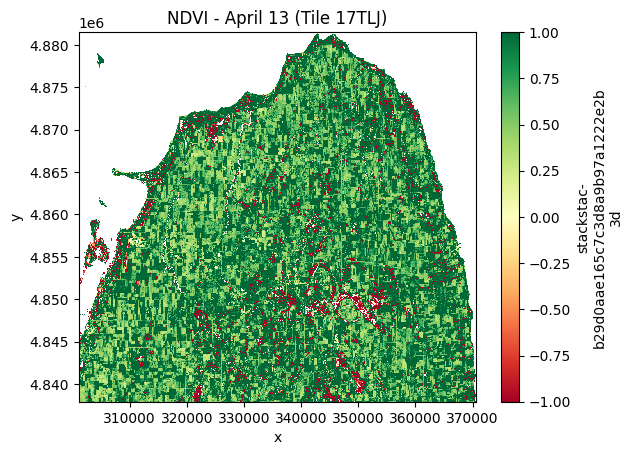

In [11]:
ndvi_20240413_17TLJ.plot(cmap="RdYlGn")
plt.title("NDVI - April 13 (Tile 17TLJ)")
plt.show()


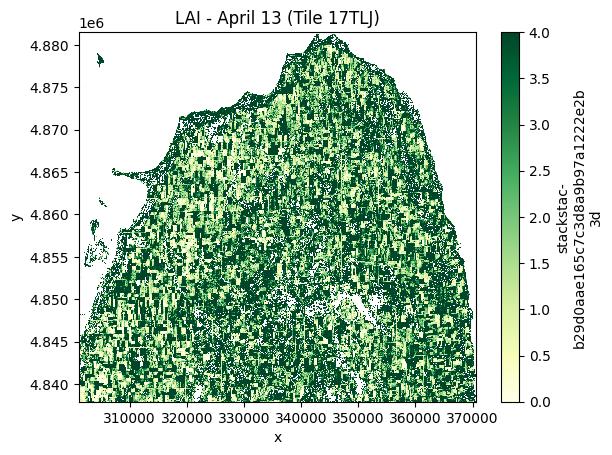

In [12]:
lai_20240413_17TLJ.plot(cmap="YlGn")
plt.title("LAI - April 13 (Tile 17TLJ)")
plt.show()


### 2025

In [13]:
import json
from shapely.geometry import shape
from pystac_client import Client
import numpy as np

# April 19 2023
# April 13 2024
# April 20 2025

# --- User-defined inputs ---
target_date = np.datetime64("2025-04-20")
days_window = 30  # how many days before/after target to search
n_closest = 3     # how many closest scenes you want
required_tile = "17TLJ"  # Sentinel-2 tile to filter on

# --- Load AOI geometry ---
with open("huron_county.geojson") as f:
    geojson = json.load(f)
geometry = shape(geojson["features"][0]["geometry"])

# --- STAC search around the target date ---
start = str(target_date)
end = str(target_date + np.timedelta64(days_window, "D"))

catalog = Client.open("https://earth-search.aws.element84.com/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime=f"{start}/{end}",
    query={"eo:cloud_cover": {"lt": 5}},
    max_items=100
)
items_all = list(search.items())

# --- Filter to only items strictly after the target date ---
items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]

# --- Further filter by tile ID ---
items_after = [item for item in items_after if item.id.split("_")[1] == required_tile]

# --- Sort by time (soonest after target date) ---
items_after.sort(key=lambda item: np.datetime64(item.datetime))

# --- Take top N closest items after the date ---
items = items_after[:n_closest]

print(f"Using {len(items)} closest Sentinel-2 scenes after {target_date} from tile {required_tile}:")
for item in items:
    print(item.id, item.datetime)

Using 2 closest Sentinel-2 scenes after 2025-04-20 from tile 17TLJ:
S2B_17TLJ_20250511_0_L2A 2025-05-11 16:41:17.158000+00:00
S2C_17TLJ_20250516_0_L2A 2025-05-16 16:41:32.665000+00:00


C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\1625272084.py:36: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]
C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\1625272084.py:42: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after.sort(key=lambda item: np.datetime64(item.datetime))


In [14]:
import stackstac
import xarray as xr
import numpy as np

from pyproj import Transformer
from shapely.ops import transform

# --- Transform AOI to UTM ---
project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds

# --- Loop through items ---
for item in items:
    date_str = item.datetime.strftime("%Y%m%d")
    tile_id = item.id.split("_")[1]  # e.g., "17TLJ" from "S2A_17TLJ_..."

    var_suffix = f"{date_str}_{tile_id}"  # e.g., "20230427_17TLJ"

    # Stack only this item
    stack = stackstac.stack(
        [item],
        assets=["red", "nir", "scl"],
        resolution=10,
        epsg=32617,
        bounds=(minx, miny, maxx, maxy),
        dtype="float64"
    )

    # Extract bands
    red = stack.sel(band="red").squeeze()
    nir = stack.sel(band="nir").squeeze()
    scl = stack.sel(band="scl").squeeze()

    # Cloud/shadow/snow mask
    bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]
    valid_mask = ~scl.isin(bad_scl)

    red_masked = red.where(valid_mask)
    nir_masked = nir.where(valid_mask)

    # NDVI
    ndvi = (nir_masked - red_masked) / (nir_masked + red_masked)
    ndvi = ndvi.clip(min=-1.0, max=1.0)

    # LAI
    ndvi_clean = ndvi.where(ndvi > 0.2)
    lai = 6.0 * ndvi_clean - 2.0
    lai = lai.clip(min=0)

    # Save to uniquely named variables
    globals()[f"ndvi_{var_suffix}"] = ndvi
    globals()[f"lai_{var_suffix}"] = lai

    print(f"Saved NDVI and LAI to variables: ndvi_{var_suffix}, lai_{var_suffix}")


Saved NDVI and LAI to variables: ndvi_20250511_17TLJ, lai_20250511_17TLJ
Saved NDVI and LAI to variables: ndvi_20250516_17TLJ, lai_20250516_17TLJ


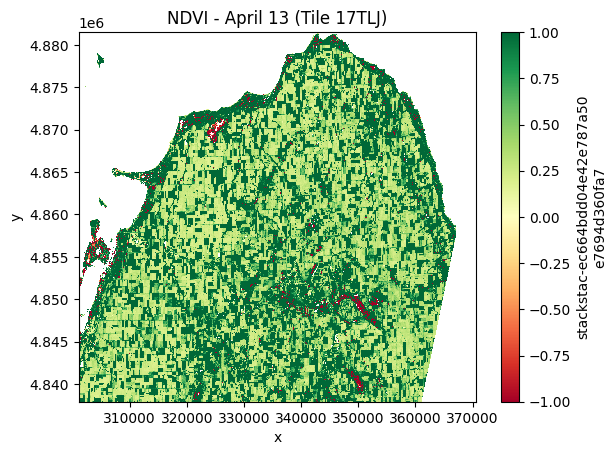

In [15]:
ndvi_20250511_17TLJ.plot(cmap="RdYlGn")
plt.title("NDVI - April 13 (Tile 17TLJ)")
plt.show()


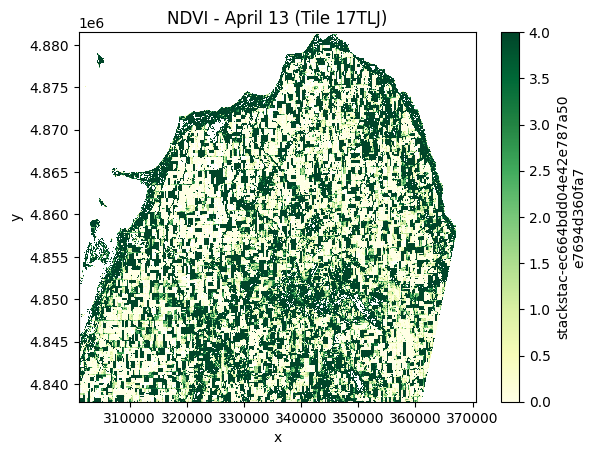

In [16]:
lai_20250511_17TLJ.plot(cmap="YlGn")
plt.title("NDVI - April 13 (Tile 17TLJ)")
plt.show()


## Scaling 

didnt actually end up using this really, but not a bad idea to compare across time

### Get GDD

In [22]:
import requests
import pandas as pd
import io
import os
from calendar import monthrange

def download_nclimgrid_county(var, start_year=2023, end_year=2025, save_folder="noaa_data"):
    os.makedirs(save_folder, exist_ok=True)
    base_url = "https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages"
    all_dfs = []

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == 2025 and month > 5:
                break  # Stop after April 2025

            ym = f"{year}{month:02d}"
            url = f"{base_url}/{year}/{var}-{ym}-cty-scaled.csv"
            print(f"📥 Downloading {url}")
            try:
                r = requests.get(url)
                r.raise_for_status()

                # Read CSV with no header
                df = pd.read_csv(io.StringIO(r.text), header=None)

                # Drop columns with any -999.99
                df = df.loc[:, ~(df == -999.99).any()]

                # Figure out how many days in the month
                days_in_month = monthrange(year, month)[1]

                # Assign column names
                col_names = ['index', 'level', 'fips', 'year', 'month', 'obs']
                day_columns = [str(day) for day in range(1, days_in_month + 1)]
                df.columns = col_names + day_columns

                # Reshape to long format
                df_long = df.melt(
                    id_vars=['level', 'fips', 'year', 'month', 'obs'],
                    value_vars=day_columns,
                    var_name='day',
                    value_name=var
                )

                # Convert to datetime
                df_long['day'] = df_long['day'].astype(int)
                df_long['date'] = pd.to_datetime(dict(
                    year=df_long['year'],
                    month=df_long['month'],
                    day=df_long['day']
                ))

                # ✅ Convert Celsius to Fahrenheit
                df_long[var] = df_long[var] * 9 / 5 + 32

                # Optional: Keep only relevant columns
                df_long = df_long[['fips', 'level', 'obs', 'date', var]]

                all_dfs.append(df_long)

                # Save raw CSV
                with open(f"{save_folder}/{var}-{ym}-cty-scaled.csv", "w") as f:
                    f.write(r.text)

            except requests.HTTPError as e:
                print(f"⚠️ Failed to download {url}: {e}")

    # Combine all monthly long-format data
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

# 🔁 Download & convert both Tmin and Tmax
tmin_df = download_nclimgrid_county("tmin")
tmax_df = download_nclimgrid_county("tmax")

# 💾 Save final long-format CSVs
tmin_df.to_csv("tmin_county_2023_2025_long.csv", index=False)
tmax_df.to_csv("tmax_county_2023_2025_long.csv", index=False)

print("✅ Download, reshaping, and Fahrenheit conversion complete.")


📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202301-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202302-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202303-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202304-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202305-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202306-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202307-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202308-cty-scaled.csv
📥 Downloading https://www.ncei.noaa.gov/pub/data/daily-grids/v1-0-0/averages/2023/tmin-202309-cty-scaled.csv
📥 Downloading https

KeyboardInterrupt: 

In [ ]:
# tmin_df=pl.read_csv("tmin_county_2023_2025_long.csv")
# tmax_df=pl.read_csv("tmax_county_2023_2025_long.csv")

In [18]:
#convert them to polars
tmax=pl.DataFrame(tmax_df)
tmax=tmax.select(['level','date','tmax','fips'])
tmin=pl.DataFrame(tmin_df)
tmin=tmin.select(['level','date','tmin','fips'])

temp_df=tmax.join(tmin,on=['level','date','fips'])
temp_df=temp_df.sort(['level','date'])


GDD Calculation

In [19]:
#base is 32
#upper limit is 86
# GDD minimum: if tmin > 86, cap at 86; if tmin < 32, floor at 32
temp_df = temp_df.with_columns(
    pl.when(pl.col("tmin") > 86)
      .then(86)
    .when(pl.col("tmin") < 32)
      .then(32)
    .otherwise(pl.col("tmin"))
    .alias("gdd_min")
)

# GDD maximum: if tmax < 32, raise to 32; if tmax > 86, cap at 86
temp_df = temp_df.with_columns(
    pl.when(pl.col("tmax") < 32)
      .then(32)
    .when(pl.col("tmax") > 86)
      .then(86)
    .otherwise(pl.col("tmax"))
    .alias("gdd_max")
)

temp_df=temp_df.with_columns(
    (((pl.col('gdd_max')+pl.col('gdd_min'))/pl.lit(2))-pl.lit(32))
    .alias('GDU')
)

temp_df = temp_df.with_columns(
    pl.col("date").dt.year().alias("year")
)


temp_df=temp_df.with_columns(
    (pl.col('GDU').cum_sum().over(['level','year']))
    .alias('AGDD')
)

In [20]:
temp_df

shape: (2_644_057, 10)
┌───────┬─────────────────────┬────────┬───────────────────┬───┬─────────┬────────┬──────┬─────────┐
│ level ┆ date                ┆ tmax   ┆ fips              ┆ … ┆ gdd_max ┆ GDU    ┆ year ┆ AGDD    │
│ ---   ┆ ---                 ┆ ---    ┆ ---               ┆   ┆ ---     ┆ ---    ┆ ---  ┆ ---     │
│ i64   ┆ datetime[ns]        ┆ f64    ┆ str               ┆   ┆ f64     ┆ f64    ┆ i32  ┆ f64     │
╞═══════╪═════════════════════╪════════╪═══════════════════╪═══╪═════════╪════════╪══════╪═════════╡
│ 1001  ┆ 2023-01-01 00:00:00 ┆ 69.764 ┆ AL: Autauga       ┆ … ┆ 69.764  ┆ 29.295 ┆ 2023 ┆ 29.295  │
│ 1001  ┆ 2023-01-02 00:00:00 ┆ 74.786 ┆ AL: Autauga       ┆ … ┆ 74.786  ┆ 31.887 ┆ 2023 ┆ 61.182  │
│ 1001  ┆ 2023-01-03 00:00:00 ┆ 74.75  ┆ AL: Autauga       ┆ … ┆ 74.75   ┆ 34.236 ┆ 2023 ┆ 95.418  │
│ 1001  ┆ 2023-01-04 00:00:00 ┆ 74.138 ┆ AL: Autauga       ┆ … ┆ 74.138  ┆ 35.343 ┆ 2023 ┆ 130.761 │
│ 1001  ┆ 2023-01-05 00:00:00 ┆ 72.23  ┆ AL: Autauga       ┆ … ┆ 72.23   ┆ 25.281 ┆ 2023 ┆ 156.042 │
│ …     ┆ …                   ┆ …      ┆ …                 ┆ … ┆ …       ┆ …      ┆ …    ┆ …       │
│ 48045 ┆ 2025-04-26 00:00:00 ┆ 42.872 ┆ WY: Weston County ┆ … ┆ 42.872  ┆ 6.444  ┆ 2025 ┆ 762.615 │
│ 48045 ┆ 2025-04-27 00:00:00 ┆ 66.614 ┆ WY: Weston County ┆ … ┆ 66.614  ┆ 20.358 ┆ 2025 ┆ 782.973 │
│ 48045 ┆ 2025-04-28 00:00:00 ┆ 77.576 ┆ WY: Weston County ┆ … ┆ 77.576  ┆ 28.953 ┆ 2025 ┆ 811.926 │
│ 48045 ┆ 2025-04-29 00:00:00 ┆ 52.25  ┆ WY: Weston County ┆ … ┆ 52.25   ┆ 10.386 ┆ 2025 ┆ 822.312 │
│ 48045 ┆ 2025-04-30 00:00:00 ┆ 64.76  ┆ WY: Weston County ┆ … ┆ 64.76   ┆ 16.785 ┆ 2025 ┆ 839.097 │
└───────┴─────────────────────┴────────┴───────────────────┴───┴─────────┴────────┴──────┴─────────┘

In [44]:

#for may 1-11 I just used bad axe weather from this website: https://www.accuweather.com/en/us/bad-axe/48413/may-weather/333628


import polars as pl

# Step 1: Create may_weather DataFrame
may_weather = pl.DataFrame({
    "date": [
        "2025-05-01", "2025-05-02", "2025-05-03", "2025-05-04", "2025-05-05", 
        "2025-05-06", "2025-05-07", "2025-05-08", "2025-05-09", "2025-05-10", "2025-05-11"
    ],
    "tmax": [62, 55, 47, 59, 56, 65, 57, 43, 61, 63, 65],
    "tmin": [36, 41, 34, 34, 46, 46, 40, 32, 28, 43, 39]
}).with_columns(
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d")
)

# Step 2: GDD min adjustment (floor at 32, cap at 86)
may_weather = may_weather.with_columns(
    pl.when(pl.col("tmin") > 86).then(86)
     .when(pl.col("tmin") < 32).then(32)
     .otherwise(pl.col("tmin"))
     .alias("gdd_min")
)

# Step 3: GDD max adjustment (cap at 86, floor at 32)
may_weather = may_weather.with_columns(
    pl.when(pl.col("tmax") > 86).then(86)
     .when(pl.col("tmax") < 32).then(32)
     .otherwise(pl.col("tmax"))
     .alias("gdd_max")
)

# Step 4: Calculate daily GDU
may_weather = may_weather.with_columns(
    (((pl.col("gdd_max") + pl.col("gdd_min")) / 2) - 32).alias("GDU")
)

# Step 5: Calculate AGDD
may_weather = may_weather.with_columns(
    pl.col("GDU").cum_sum().alias("AGDD")
)


end_2025 = may_weather.filter(pl.col('date') == pl.lit(datetime.date(2025, 5, 11)))
end_2025=end_2025['AGDD'].item()



In [45]:
#Predicted Green-up dates
# April 19 2023
# April 13 2024
# April 20 2025

#Image dates
#May 9 2023
#April 13 2024
#May 11 2025


huron_df=temp_df.filter(pl.col('fips')=='MI: Huron County')

start_2023 = huron_df.filter(pl.col("date") == pl.lit(datetime.date(2023, 4, 19)))
start_2023=start_2023['AGDD'].item()
end_2023 = huron_df.filter(pl.col("date") == pl.lit(datetime.date(2023, 5, 9)))
end_2023=end_2023['AGDD'].item()
diff_2023=end_2023-start_2023
# print(diff_2023)

#because our image is on april 13, we will just take the GDU and divide it by 2 and then log that
start_2024 = huron_df.filter(pl.col("date") == pl.lit(datetime.date(2024, 4, 13)))
diff_2024=(start_2024['GDU'].item())/2



#as of writing this code, it is May 29 2025 so the may 2025 temp data has not been released (or at least on the site where I got my previous data)
start_2025 = huron_df.filter(pl.col("date") == pl.lit(datetime.date(2025, 4, 20)))
start_2025=start_2025['AGDD'].item()

#I will just find the AGDD from May 1st to May 11th and then add that to the AGDD from April 30
april30_2025= huron_df.filter(pl.col("date") == pl.lit(datetime.date(2025, 4, 30)))
april30_2025=april30_2025['AGDD'].item()

end_2025=april30_2025+end_2025
diff_2025=end_2025-start_2025


In [46]:
log_diff_2023=np.log(diff_2023)
log_diff_2024=np.log(diff_2024)
log_diff_2025=np.log(diff_2025)

print(log_diff_2023)
print(log_diff_2024)
print(log_diff_2025)



5.64329971777646
1.7915094379728458
5.952536591097146


### Scale NDVI and LAI by log GDD diff

In [74]:
import json
from shapely.geometry import shape
from pystac_client import Client
from pyproj import Transformer
from shapely.ops import transform
import stackstac
import xarray as xr
import pandas as pd



# Step 1: Load the GeoJSON file
with open("huron_county.geojson") as f:
    geojson = json.load(f)

# Step 2: Extract the geometry (assumes single feature)
geometry = shape(geojson["features"][0]["geometry"])

# Step 3: Transform AOI to UTM (EPSG:32617 for 17TLJ)
project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds

# Step 4: Define STAC search parameters for 3 separate periods
catalog = Client.open("https://earth-search.aws.element84.com/v1")

def fetch_items(start, end,required_tile="17TLJ"):
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=geometry,
        datetime=f"{start}/{end}",
        query={"eo:cloud_cover": {"lt": 30}},
        max_items=500
    )


    items_all = list(search.items())

# --- Filter to only items with required tile ---
    items_after = [item for item in items_all if item.id.split("_")[1] == required_tile]
    

    return items_after





# Three periods
items_2023 = fetch_items("2023-04-19", "2023-05-19")
items_2024 = fetch_items("2024-04-13", "2024-04-14")
items_2025 = fetch_items("2025-04-20", "2025-05-20")

# Combine all items
all_items = items_2023 + items_2024 + items_2025

# Step 5: Stack data
stack = stackstac.stack(
    all_items,
    assets=["red", "nir", "scl"],
    resolution=10,
    epsg=32617,
    bounds=(minx, miny, maxx, maxy),
    dtype="float64"
)

# Step 6: Extract bands
red = stack.sel(band="red")
nir = stack.sel(band="nir")
scl = stack.sel(band="scl")

# Step 7: Mask clouds/shadow/snow using SCL
cloud_mask = ~scl.isin([1, 3, 8, 9, 10, 11])
red_masked = red.where(cloud_mask)
nir_masked = nir.where(cloud_mask)

# Step 8: Compute NDVI
ndvi = (nir_masked - red_masked) / (nir_masked + red_masked)
ndvi = ndvi.clip(min=-1.0, max=1.0)

# Step 9: Compute mean NDVI per image
mean_ndvi_ts = ndvi.mean(dim=["x", "y"], skipna=True)
dates=mean_ndvi_ts["time"].values
# # Step 10: Convert to DataFrame
# ndvi_df = pd.DataFrame({
#     "date": pd.to_datetime(mean_ndvi_ts["time"].values),
#     "mean_ndvi": mean_ndvi_ts.values
# })


In [75]:
import numpy as np

# Get number of time steps
n_time = mean_ndvi_ts.sizes["time"]

# Get time values (optional metadata)
time_values = mean_ndvi_ts.time.values

# Initialize list to store values
ndvi_mean_list = []

# Loop through each time slice
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    value = mean_ndvi_ts.isel(time=t).values.item()  # get scalar float
    ndvi_mean_list.append(value)

# Convert to NumPy array
ndvi_mean_array = np.array(ndvi_mean_list)
print("✅ Mean NDVI time series shape:", ndvi_mean_array.shape)


Extracting time index 1/9...
Extracting time index 2/9...
Extracting time index 3/9...
Extracting time index 4/9...
Extracting time index 5/9...
Extracting time index 6/9...
Extracting time index 7/9...
Extracting time index 8/9...
Extracting time index 9/9...
✅ Mean NDVI time series shape: (9,)


In [79]:
df = pd.DataFrame(zip(time_values, ndvi_mean_array), columns=['date', 'Mean NDVI'])


# Drop row at index 5
df = df.drop(index=5).reset_index(drop=True)



# AGDD values in the same order as the DataFrame rows
agdd_values = [741.33, 830.52, 933.993, 1134.954, 607.977, 684.909, 860.909, 1207.909]

# Add AGDD column to your existing DataFrame
df["AGDD"] = agdd_values

# Preview the updated DataFrame
df


date  Mean NDVI      AGDD
0 2023-04-27 16:41:16.124   0.417959   741.330
1 2023-05-04 16:31:20.077   0.487573   830.520
2 2023-05-09 16:31:22.398   0.492618   933.993
3 2023-05-17 16:41:17.603   0.521311  1134.954
4 2024-04-13 16:31:20.466   0.526750   607.977
5 2025-04-28 16:41:30.353   0.463071   684.909
6 2025-05-11 16:41:17.158   0.467508   860.909
7 2025-05-16 16:41:32.665   0.520072  1207.909

In [83]:
from scipy.optimize import curve_fit
import numpy as np

# Define a logistic-like function (NDVI vs AGDD often follows S-curve)
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Fit curve
xdata = df["AGDD"].values
ydata = df["Mean NDVI"].values

popt, _ = curve_fit(logistic, xdata, ydata, maxfev=10000)

# Predict NDVI from fitted model
df["NDVI_pred"] = logistic(df["AGDD"], *popt)

# Normalize by dividing actual by predicted
df["NDVI_normalized"] = df["Mean NDVI"] / df["NDVI_pred"]


C:\Users\Porter\AppData\Local\Temp\ipykernel_32188\690523399.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic, xdata, ydata, maxfev=10000)


In [85]:
# ndvi_value = 0.52
agdd_value_2023 = 933.933
agdd_value_2024=607.977
agdd_value_2025=860.909

ndvi_pred_2023 = logistic(agdd_value_2023, *popt)
ndvi_pred_2024 = logistic(agdd_value_2024, *popt)
ndvi_pred_2025 = logistic(agdd_value_2025, *popt)





In [87]:
#Predicted Green-up dates
# April 19 2023
# April 13 2024
# April 20 2025

#Image dates
#May 9 2023
#April 13 2024
#May 11 2025


# ndvi_20230509_17TLJ_scaled=ndvi_20230509_17TLJ/log_diff_2023
# ndvi_20240413_17TLJ_scaled=ndvi_20240413_17TLJ/log_diff_2024
# ndvi_20250511_17TLJ_scaled=ndvi_20250511_17TLJ/log_diff_2025

# lai_20230509_17TLJ_scaled=lai_20230509_17TLJ/log_diff_2023
# lai_20240413_17TLJ_scaled=lai_20240413_17TLJ/log_diff_2024
# lai_20250511_17TLJ_scaled=lai_20250511_17TLJ/log_diff_2025


ndvi_20230509_17TLJ_scaled=ndvi_20230509_17TLJ/ndvi_pred_2023
ndvi_20240413_17TLJ_scaled=ndvi_20240413_17TLJ/ndvi_pred_2024
ndvi_20250511_17TLJ_scaled=ndvi_20250511_17TLJ/ndvi_pred_2025

lai_20230509_17TLJ_scaled=lai_20230509_17TLJ/ndvi_pred_2023
lai_20240413_17TLJ_scaled=lai_20240413_17TLJ/ndvi_pred_2024
lai_20250511_17TLJ_scaled=lai_20250511_17TLJ/ndvi_pred_2025

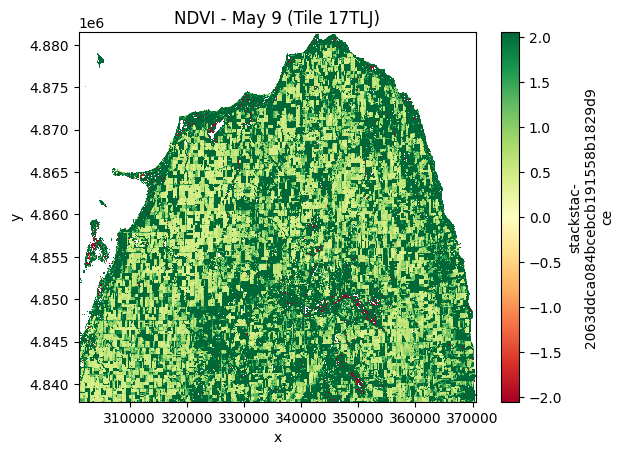

In [88]:
ndvi_20230509_17TLJ_scaled.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()


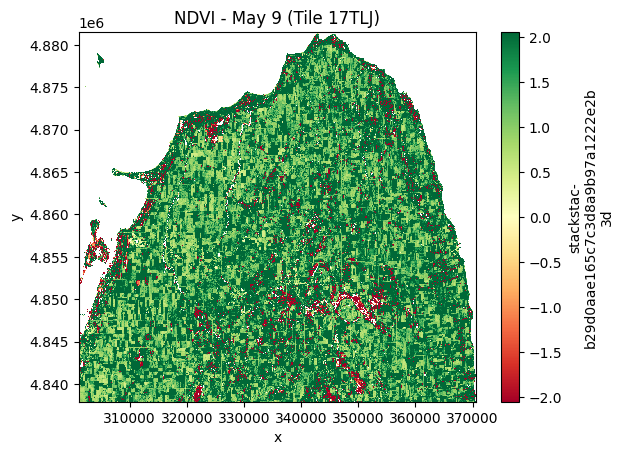

In [89]:
ndvi_20240413_17TLJ_scaled.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()

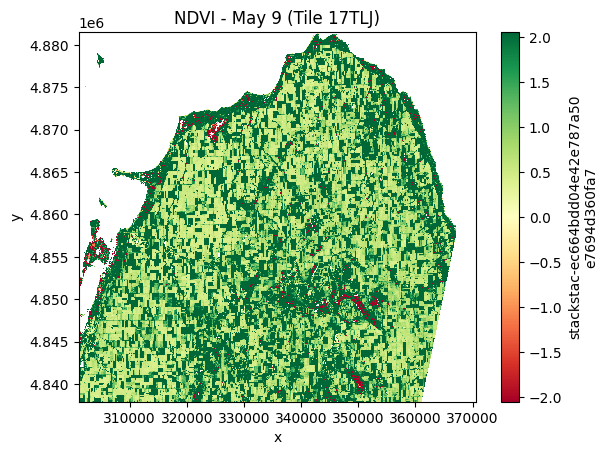

In [90]:
ndvi_20250511_17TLJ_scaled.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()

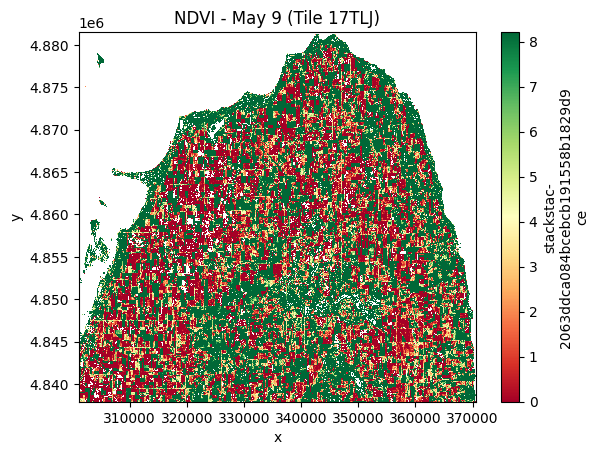

In [91]:
lai_20230509_17TLJ_scaled.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()

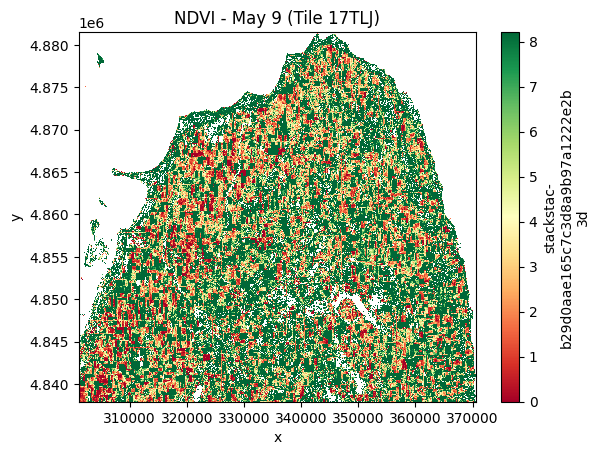

In [92]:
lai_20240413_17TLJ_scaled.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()

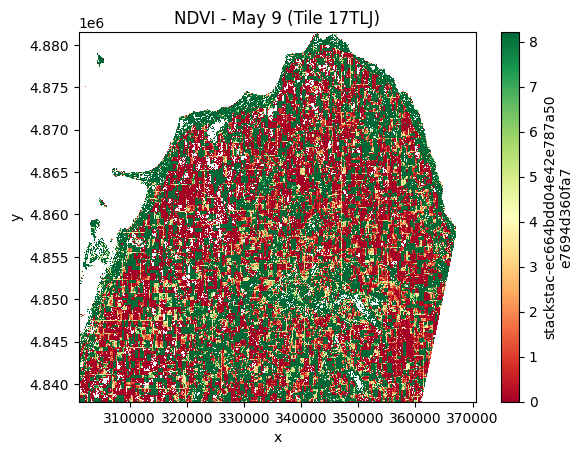

In [93]:
lai_20250511_17TLJ_scaled.plot(cmap="RdYlGn")
plt.title("NDVI - May 9 (Tile 17TLJ)")
plt.show()

## Making Training Data

In [153]:
import rioxarray as rxr
from tqdm.auto import tqdm
import threading
import time

# Load wheat mask GeoTIFF for 2023
mask_2023 = rxr.open_rasterio(r"rasterized_masks\winter_wheat_mask_2023.tif").squeeze()

# List of 2023 variable base names
variable_names_2023 = [
    "ndvi", "evi", "ndre", "ndwi", "lai", 
    "red", "green", "blue", "nir", 
    "rededge1", "rededge2", "rededge3", 
    "swir16", "swir22", "nir08"
]

# Progress bar helper
def show_progress(label, done_flag):
    with tqdm(desc=label, total=100) as pbar:
        while not done_flag[0]:
            pbar.update(1)
            time.sleep(0.1)
        pbar.n = 100
        pbar.refresh()

def reproject_with_progress(label, arr, match):
    done = [False]
    thread = threading.Thread(target=show_progress, args=(label, done))
    thread.start()
    result = arr.rio.reproject_match(match)
    done[0] = True
    thread.join()
    return result

# Assign CRS and reproject each 2023 variable with progress bar
for var in variable_names_2023:
    var_2023 = globals()[f"{var}_20230509_17TLJ"]

    # Set CRS
    var_2023.rio.write_crs("EPSG:32617", inplace=True)

    # Reproject to match 2023 mask with progress bar
    globals()[f"{var}_2023"] = reproject_with_progress(f"Reprojecting {var.upper()} 2023", var_2023, mask_2023)


Reprojecting NDVI 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting EVI 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NDRE 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NDWI 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting LAI 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting RED 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting GREEN 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting BLUE 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NIR 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting REDEDGE1 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting REDEDGE2 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting REDEDGE3 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting SWIR16 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting SWIR22 2023:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NIR08 2023:   0%|          | 0/100 [00:00<?, ?it/s]

In [154]:
import pandas as pd
import numpy as np

def make_tabular_from_dict(data_dict, mask):
    """
    Converts a dictionary of 2D reprojected xarray variables into a flat tabular DataFrame.
    Assumes all arrays are aligned and same shape.
    
    Parameters:
        data_dict (dict): Keys are column names, values are xarray.DataArray (2D).
        mask (xarray.DataArray): Wheat mask aligned with data.

    Returns:
        pd.DataFrame: Tabular data with all features + wheat label.
    """
    tabular_data = {}

    # Flatten each variable and add to dict
    for key, arr in data_dict.items():
        tabular_data[key.upper()] = arr.values.flatten()

    # Add flattened wheat mask
    tabular_data["WHEAT"] = mask.values.flatten().astype(int)

    # Create DataFrame
    df = pd.DataFrame(tabular_data)

    # Drop any rows with NaNs
    df = df.dropna()

    return df

# Gather all your reprojected 2023 variables into a dictionary
data_2023 = {
    "ndvi": ndvi_2023,
    "evi": evi_2023,
    "ndre": ndre_2023,
    "ndwi": ndwi_2023,
    "lai": lai_2023,
    "red": red_2023,
    "green": green_2023,
    "blue": blue_2023,
    "nir": nir_2023,
    "rededge1": rededge1_2023,
    "rededge2": rededge2_2023,
    "rededge3": rededge3_2023,
    "swir16": swir16_2023,
    "swir22": swir22_2023,
    "nir08": nir08_2023
}

# Create the tabular DataFrame
df_2023 = make_tabular_from_dict(data_2023, mask_2023)

# Preview
print(df_2023.head())
print(f"✅ df_2023 shape: {df_2023.shape}")


Exception ignored in: <function CachingFileManager.__del__ at 0x000001EC2ACBCEA0>
Traceback (most recent call last):
  File "c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\xarray\backends\file_manager.py", line 252, in __del__
    self._lock.release()
  File "c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\xarray\backends\locks.py", line 61, in release
    return self.lock.release(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


            NDVI       EVI      NDRE      NDWI  LAI     RED   GREEN    BLUE  \
101326  1.000000  0.249559  0.786667  0.060486  4.0 -0.0306 -0.0297 -0.0448   
101327  1.000000  0.247607  0.788280  0.064716  4.0 -0.0280 -0.0256 -0.0415   
101336  1.000000  0.266948  0.654997  0.057340  4.0 -0.0131 -0.0230 -0.0385   
101337  1.000000  0.203384  0.497683 -0.178444  4.0 -0.0216 -0.0270 -0.0410   
101342  0.281931 -0.089929  0.303246  0.113667  0.0 -0.0461 -0.0280 -0.0487   

           NIR  REDEDGE1  REDEDGE2  REDEDGE3  SWIR16  SWIR22   NIR08  WHEAT  
101326  0.0938    0.0112    0.0485    0.0595  0.0831  0.0128  0.0871      0  
101327  0.0946    0.0112    0.0485    0.0595  0.0831  0.0128  0.0871      0  
101336  0.1300    0.0271    0.0666    0.0896  0.1159  0.0364  0.1114      0  
101337  0.0808    0.0271    0.0666    0.0896  0.1159  0.0364  0.1114      0  
101342 -0.0823   -0.0440   -0.0681   -0.0578 -0.0655 -0.0766 -0.0625      0  
✅ df_2023 shape: (21012732, 16)


In [156]:
df_2023

NDVI       EVI      NDRE      NDWI       LAI     RED   GREEN  \
101326    1.000000  0.249559  0.786667  0.060486  4.000000 -0.0306 -0.0297   
101327    1.000000  0.247607  0.788280  0.064716  4.000000 -0.0280 -0.0256   
101336    1.000000  0.266948  0.654997  0.057340  4.000000 -0.0131 -0.0230   
101337    1.000000  0.203384  0.497683 -0.178444  4.000000 -0.0216 -0.0270   
101342    0.281931 -0.089929  0.303246  0.113667  0.000000 -0.0461 -0.0280   
...            ...       ...       ...       ...       ...     ...     ...   
30241927  1.000000  0.198814  0.587755 -0.275942  4.000000 -0.0228 -0.0278   
30241928  1.000000  0.268629  0.649913 -0.190132  4.000000 -0.0366 -0.0350   
30241929  1.000000  0.356496  0.775306  0.065776  4.000000 -0.0295 -0.0258   
30241930  1.000000  0.370810  0.335298 -0.032051  4.000000 -0.0126  0.0002   
30241931  0.464621  0.175117  0.311450 -0.058630  0.787724  0.0628  0.0282   

            BLUE     NIR  REDEDGE1  REDEDGE2  REDEDGE3  SWIR16  SWIR22  \
101326   -0.0448  0.0938    0.0112    0.0485    0.0595  0.0831  0.0128   
101327   -0.0415  0.0946    0.0112    0.0485    0.0595  0.0831  0.0128   
101336   -0.0385  0.1300    0.0271    0.0666    0.0896  0.1159  0.0364   
101337   -0.0410  0.0808    0.0271    0.0666    0.0896  0.1159  0.0364   
101342   -0.0487 -0.0823   -0.0440   -0.0681   -0.0578 -0.0655 -0.0766   
...          ...     ...       ...       ...       ...     ...     ...   
30241927 -0.0432  0.0778    0.0202    0.0560    0.0779  0.1371  0.0699   
30241928 -0.0468  0.0952    0.0202    0.1084    0.1271  0.1399  0.0524   
30241929 -0.0458  0.1596    0.0202    0.1084    0.1271  0.1399  0.0524   
30241930 -0.0268  0.1812    0.0902    0.1532    0.1836  0.1932  0.1525   
30241931 -0.0010  0.1718    0.0902    0.1532    0.1836  0.1932  0.1525   

           NIR08  WHEAT  
101326    0.0871      0  
101327    0.0871      0  
101336    0.1114      0  
101337    0.1114      0  
101342   -0.0625      0  
...          ...    ...  
30241927  0.1070      0  
30241928  0.1592      0  
30241929  0.1592      0  
30241930  0.2219      0  
30241931  0.2219      0  

[21012732 rows x 16 columns]

## Modeling

Training Random Forest:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distrib

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97   3363645
           1       0.95      0.81      0.87    838902

    accuracy                           0.95   4202547
   macro avg       0.95      0.90      0.92   4202547
weighted avg       0.95      0.95      0.95   4202547



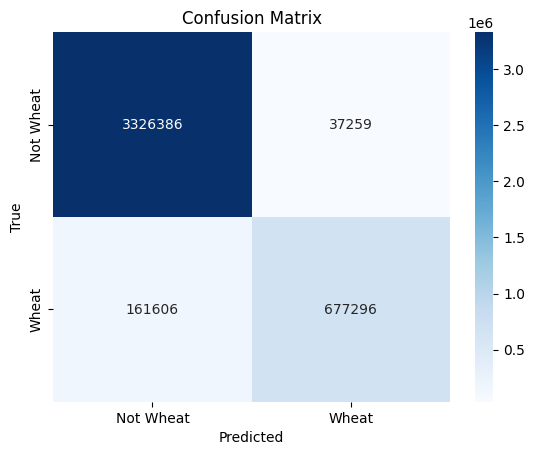

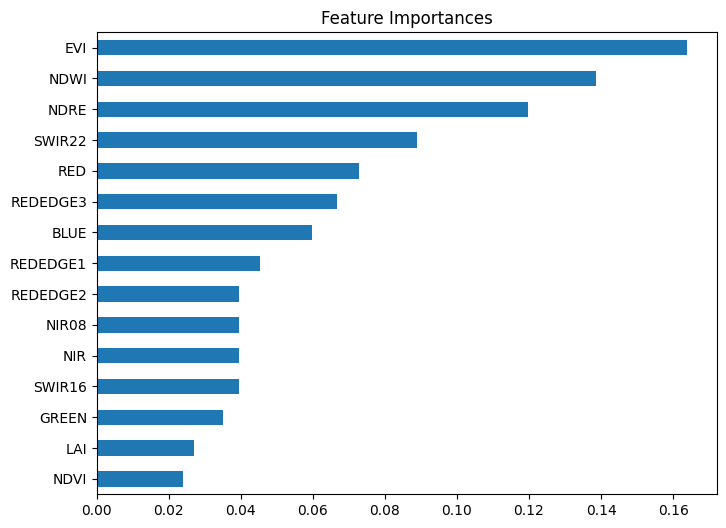

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

# 1. Define features and target
feature_cols = [col for col in df_2023.columns if col.upper() != "WHEAT"]
X = df_2023[feature_cols]
y = df_2023["WHEAT"]

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train Random Forest with progress bar

n_trees = 100
clf = RandomForestClassifier(
    n_estimators=1,  
    warm_start=True,  #this allows us to train 100 trees but incrementallyS
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

for i in tqdm(range(1, n_trees + 1), desc="Training Random Forest"):
    clf.n_estimators = i
    clf.fit(X_train, y_train)

# 4. Evaluate
y_pred = clf.predict(X_test)
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Wheat", "Wheat"],
            yticklabels=["Not Wheat", "Wheat"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 6. Feature Importance
importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=feature_cols)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importances")
plt.show()


In [159]:
import joblib
joblib.dump(clf, "rf_crop_id.pkl")


['rf_crop_id.pkl']

In [ ]:
# # Load the model from the file
# clf = joblib.load("rf_crop_id.pkl")

## Using it on 2025 data

In [2]:
import json
from shapely.geometry import shape
from pystac_client import Client
import numpy as np

# April 19 2023
# April 13 2024
# April 20 2025

# --- User-defined inputs ---
target_date = np.datetime64("2025-04-20")
days_window = 30  # how many days before/after target to search
n_closest = 3     # how many closest scenes you want
required_tile = "17TLJ"  # Sentinel-2 tile to filter on

# --- Load AOI geometry ---
with open("huron_county.geojson") as f:
    geojson = json.load(f)
geometry = shape(geojson["features"][0]["geometry"])

# --- STAC search around the target date ---
start = str(target_date)
end = str(target_date + np.timedelta64(days_window, "D"))

catalog = Client.open("https://earth-search.aws.element84.com/v1")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime=f"{start}/{end}",
    query={"eo:cloud_cover": {"lt": 20}},
    max_items=100
)
items_all = list(search.items())

# --- Filter to only items strictly after the target date ---
items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]

# --- Further filter by tile ID ---
items_after = [item for item in items_after if item.id.split("_")[1] == required_tile]

# --- Sort by time (soonest after target date) ---
items_after.sort(key=lambda item: np.datetime64(item.datetime))

# --- Take top N closest items after the date ---
items = items_after[:n_closest]

print(f"Using {len(items)} closest Sentinel-2 scenes after {target_date} from tile {required_tile}:")
for item in items:
    print(item.id, item.datetime)


Using 3 closest Sentinel-2 scenes after 2025-04-20 from tile 17TLJ:
S2B_17TLJ_20250428_0_L2A 2025-04-28 16:31:21.290000+00:00
S2A_17TLJ_20250428_1_L2A 2025-04-28 16:41:30.353000+00:00
S2B_17TLJ_20250511_0_L2A 2025-05-11 16:41:17.158000+00:00


C:\Users\Porter\AppData\Local\Temp\ipykernel_15824\1847358572.py:36: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after = [item for item in items_all if np.datetime64(item.datetime) > target_date]
C:\Users\Porter\AppData\Local\Temp\ipykernel_15824\1847358572.py:42: UserWarning: no explicit representation of timezones available for np.datetime64
  items_after.sort(key=lambda item: np.datetime64(item.datetime))


In [3]:
from pyproj import Transformer
from shapely.ops import transform

# --- Transform AOI to UTM ---
project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds


# Bands to use
bands_to_use = [
    "red", "green", "blue", "nir", "rededge1", "rededge2", "rededge3",
    "swir16", "swir22", "scl","nir08"
]

# Vegetation index functions
def compute_evi(nir, red, blue):
    return 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)

def compute_ndre(nir, rededge):
    return (nir - rededge) / (nir + rededge)

def compute_ndwi(nir, swir16):
    return (nir - swir16) / (nir + swir16)



for item in items:
    date_str = item.datetime.strftime("%Y%m%d")
    tile_id = item.id.split("_")[1]
    var_suffix = f"{date_str}_{tile_id}"

    stack = stackstac.stack(
        [item],
        assets=bands_to_use,
        resolution=10,
        epsg=32617,
        bounds=(minx, miny, maxx, maxy),
        dtype="float64"
    )

    red = stack.sel(band="red").squeeze()
    green = stack.sel(band="green").squeeze()
    blue = stack.sel(band="blue").squeeze()
    nir = stack.sel(band="nir").squeeze()
    rededge1 = stack.sel(band="rededge1").squeeze()
    rededge2 = stack.sel(band="rededge2").squeeze()
    rededge3 = stack.sel(band="rededge3").squeeze()
    swir16 = stack.sel(band="swir16").squeeze()
    swir22 = stack.sel(band="swir22").squeeze()
    scl = stack.sel(band="scl").squeeze()
    nir08=stack.sel(band="nir08").squeeze()

    bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]
    valid_mask = ~scl.isin(bad_scl)

    red = red.where(valid_mask)
    green = green.where(valid_mask)
    blue = blue.where(valid_mask)
    nir = nir.where(valid_mask)
    rededge1 = rededge1.where(valid_mask)
    rededge2 = rededge2.where(valid_mask)
    rededge3 = rededge3.where(valid_mask)
    swir16 = swir16.where(valid_mask)
    swir22 = swir22.where(valid_mask)
    nir08 = nir08.where(valid_mask)


    ndvi = (nir - red) / (nir + red)
    ndvi = ndvi.clip(min=-1, max=1)

    evi = compute_evi(nir, red, blue).clip(min=-1, max=1)
    ndre = compute_ndre(nir, rededge1).clip(min=-1, max=1)

    ndwi = compute_ndwi(nir, swir16).clip(min=-1, max=1)


    lai = 6.0 * ndvi.where(ndvi > 0.2) - 2.0
    lai = lai.clip(min=0)

    ds = xr.Dataset({
        "ndvi": ndvi,
        "evi": evi,
        "ndre": ndre,
        "ndwi": ndwi,
        "lai": lai,
        "red": red,
        "green": green,
        "blue": blue,
        "nir": nir,
        "rededge1": rededge1,
        "rededge2": rededge2,
        "rededge3": rededge3,
        "swir16": swir16,
        "swir22": swir22,
        "nir08": nir08
    })

   # Save all computed bands and indices to globals
for name, arr in ds.data_vars.items():
    globals()[f"{name}_{var_suffix}"] = arr
    print(f"Saved {name}_{var_suffix}")

Saved ndvi_20250511_17TLJ
Saved evi_20250511_17TLJ
Saved ndre_20250511_17TLJ
Saved ndwi_20250511_17TLJ
Saved lai_20250511_17TLJ
Saved red_20250511_17TLJ
Saved green_20250511_17TLJ
Saved blue_20250511_17TLJ
Saved nir_20250511_17TLJ
Saved rededge1_20250511_17TLJ
Saved rededge2_20250511_17TLJ
Saved rededge3_20250511_17TLJ
Saved swir16_20250511_17TLJ
Saved swir22_20250511_17TLJ
Saved nir08_20250511_17TLJ


In [4]:
import rioxarray as rxr
from tqdm.auto import tqdm
import threading
import time

# Load wheat mask GeoTIFF for 2023 (used for alignment)
mask_2023 = rxr.open_rasterio(r"rasterized_masks\winter_wheat_mask_2023.tif").squeeze()

# List of 2025 variable base names (same as 2023, but different date)
variable_names = [
    "ndvi", "evi", "ndre", "ndwi", "lai", 
    "red", "green", "blue", "nir", 
    "rededge1", "rededge2", "rededge3", 
    "swir16", "swir22", "nir08"
]

# Progress bar helper
def show_progress(label, done_flag):
    with tqdm(desc=label, total=100) as pbar:
        while not done_flag[0]:
            pbar.update(1)
            time.sleep(0.1)
        pbar.n = 100
        pbar.refresh()

def reproject_with_progress(label, arr, match):
    done = [False]
    thread = threading.Thread(target=show_progress, args=(label, done))
    thread.start()
    result = arr.rio.reproject_match(match)
    done[0] = True
    thread.join()
    return result

# Assign CRS and reproject each 2025 variable
for var in variable_names:
    var_2025 = globals()[f"{var}_20250511_17TLJ"]

    # Set CRS if missing
    var_2025.rio.write_crs("EPSG:32617", inplace=True)

    # Reproject to match 2023 mask
    globals()[f"{var}_2025"] = reproject_with_progress(
        f"Reprojecting {var.upper()} 2025", var_2025, mask_2023
    )


Reprojecting NDVI 2025:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\dask\_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


Reprojecting EVI 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NDRE 2025:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\dask\_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


Reprojecting NDWI 2025:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\dask\_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


Reprojecting LAI 2025:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\dask\_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


Reprojecting RED 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting GREEN 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting BLUE 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NIR 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting REDEDGE1 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting REDEDGE2 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting REDEDGE3 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting SWIR16 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting SWIR22 2025:   0%|          | 0/100 [00:00<?, ?it/s]

Reprojecting NIR08 2025:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
import pandas as pd
import numpy as np

# Use one variable to get spatial dimensions
height, width = ndvi_2025.shape

# Stack all variables into a DataFrame
variable_names = [
    "ndvi", "evi", "ndre", "ndwi", "lai", 
    "red", "green", "blue", "nir", 
    "rededge1", "rededge2", "rededge3", 
    "swir16", "swir22", "nir08"
]

# Flatten each and build dict
flat_vars = {
    var.upper(): globals()[f"{var}_2025"].values.flatten()
    for var in variable_names
}

df_2025 = pd.DataFrame(flat_vars)

# Track which pixels are valid (not NaN)
valid_mask = ~df_2025.isna().any(axis=1)

# Filter to valid rows
df_valid = df_2025[valid_mask].copy()


In [6]:
import joblib
from tqdm.auto import tqdm
import numpy as np

# Load model
model = joblib.load("rf_crop_id.pkl")

# Predict in chunks
batch_size = 100_000  # adjust based on memory
n = len(df_valid)
preds = []

for i in tqdm(range(0, n, batch_size), desc="Predicting"):
    batch = df_valid.iloc[i:i+batch_size]
    batch_preds = model.predict(batch)
    preds.append(batch_preds)

# Combine all predictions
preds = np.concatenate(preds)


Predicting:   0%|          | 0/198 [00:00<?, ?it/s]

In [7]:
# Fill full array with NaNs
wheat_pred_map = np.full(height * width, np.nan)

# Insert predictions where valid
wheat_pred_map[valid_mask.values] = preds

# Reshape to 2D (spatial)
wheat_pred_map = wheat_pred_map.reshape((height, width))


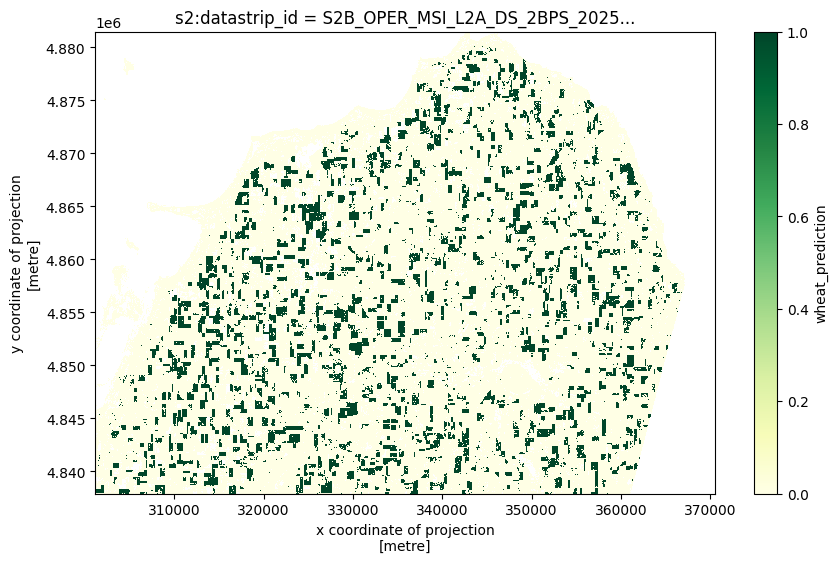

In [8]:
import xarray as xr
import rioxarray as rxr

# Use any 2025 reprojected variable as template
template = ndvi_2025  # already has CRS and transform

# Create spatial xarray
wheat_da = xr.DataArray(
    wheat_pred_map,
    coords=template.coords,
    dims=template.dims,
    name="wheat_prediction"
).rio.write_crs(template.rio.crs)

# Optional: Plot
wheat_da.plot(cmap="YlGn", figsize=(10, 6))

# Save to GeoTIFF
wheat_da.rio.to_raster("wheat_prediction_2025.tif")
